# # Predicting ICU Mortality Risk Using MIMIC-III Dataset
# # A Tutorial for Healthcare Machine Learning with Deep Learning
# 
# This Jupyter Notebook demonstrates how to predict whether a patient in the ICU will survive their hospital stay using the MIMIC-III dataset. Unlike the readmission example, we'll focus on mortality prediction and use both traditional machine learning and deep learning approaches.
# 
# ### Objectives
# 1. Load and preprocess MIMIC-III data
# 2. Engineer temporal features from ICU stays
# 3. Train multiple models (Logistic Regression, Neural Network)
# 4. Compare model performance and derive clinical insights
# 
# ### Prerequisites
# - MIMIC-III dataset (CSV files or database access)
# - Python libraries: pandas, numpy, scikit-learn, tensorflow/keras, matplotlib, seaborn

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ## Step 1: Load MIMIC-III Data
# We'll need to load several tables from MIMIC-III to build our mortality prediction model. This includes patient data, ICU stays, and vital signs.

In [2]:
# # Load required data files - update these paths to match your MIMIC-III location
# patients = pd.read_csv("PATIENTS.csv")
# admissions = pd.read_csv("ADMISSIONS.csv")
# icustays = pd.read_csv("ICUSTAYS.csv") 
# chartevents = pd.read_csv("CHARTEVENTS.csv", usecols=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM'])
# d_items = pd.read_csv("D_ITEMS.csv", usecols=['ITEMID', 'LABEL', 'DBSOURCE', 'CATEGORY'])

patients = pd.read_csv("C:\\Users\\harsh\\Desktop\\HBK008\\Holland Bloorview\\projects\\AI4H_UT\\full_dataset\\PATIENTS.csv")
admissions = pd.read_csv("C:\\Users\\harsh\\Desktop\\HBK008\\Holland Bloorview\\projects\\AI4H_UT\\full_dataset\\ADMISSIONS.csv")
icustays = pd.read_csv("C:\\Users\\harsh\\Desktop\\HBK008\\Holland Bloorview\\projects\\AI4H_UT\\full_dataset\\ICUSTAYS.csv") 
chartevents = pd.read_csv("C:\\Users\\harsh\\Desktop\\HBK008\\Holland Bloorview\\projects\\AI4H_UT\\full_dataset\\CHARTEVENTS.csv", usecols=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM'])
d_items = pd.read_csv("C:\\Users\\harsh\\Desktop\\HBK008\\Holland Bloorview\\projects\\AI4H_UT\\full_dataset\\D_ITEMS.csv", usecols=['ITEMID', 'LABEL', 'DBSOURCE', 'CATEGORY'])
# diagnoses_icd = pd.read_csv("C:\\Users\\harsh\\Desktop\\HBK008\\Holland Bloorview\\projects\\AI4H_UT\\full_dataset\\DIAGNOSES_ICD.csv")

In [3]:
# Display basic info
print("Patients Shape:", patients.shape)
print("Admissions Shape:", admissions.shape)
print("ICU Stays Shape:", icustays.shape)
print("Chart Events Sample Size:", chartevents.shape)

Patients Shape: (46520, 8)
Admissions Shape: (58976, 19)
ICU Stays Shape: (61532, 12)
Chart Events Sample Size: (120442482, 6)


# ## Step 2: Extract Target Variable - ICU Mortality
# We'll define our target variable: whether a patient died during their hospital stay after ICU admission.

In [4]:
# Convert date columns to datetime
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])

# Create mortality indicator (1 = died in hospital, 0 = survived)
admissions['HOSPITAL_MORTALITY'] = (~admissions['DEATHTIME'].isna()).astype(int)

# Join ICU stays with admissions to get mortality info
icu_outcomes = icustays.merge(
    admissions[['HADM_ID', 'HOSPITAL_MORTALITY', 'DEATHTIME']], 
    on='HADM_ID', 
    how='left'
)

# Print class distribution
mortality_counts = icu_outcomes['HOSPITAL_MORTALITY'].value_counts()
print("\nMortality Distribution:")
print(mortality_counts)
print(f"Mortality Rate: {mortality_counts[1]/len(icu_outcomes):.2%}")


Mortality Distribution:
0    54923
1     6609
Name: HOSPITAL_MORTALITY, dtype: int64
Mortality Rate: 10.74%


# ## Step 3: Feature Engineering
# Let's extract features that might be predictive of mortality, including:
# - Patient demographics (age, gender)
# - ICU stay characteristics (length of stay, first care unit)
# - Initial vital signs from first 24 hours (heart rate, blood pressure, etc.)

In [5]:
# Process patient data
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['GENDER'] = patients['GENDER'].map({'M': 1, 'F': 0})

# Process ICU stays
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
icustays['ICU_LOS_DAYS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / (24 * 60 * 60)

# One-hot encode first care unit
first_care_units = pd.get_dummies(icustays['FIRST_CAREUNIT'], prefix='UNIT')
icustays = pd.concat([icustays, first_care_units], axis=1)

# Calculate age at admission
icu_patients = icustays.merge(patients[['SUBJECT_ID', 'DOB', 'GENDER']], on='SUBJECT_ID', how='left')
icu_patients['AGE'] = (icu_patients['INTIME'].dt.year - icu_patients['DOB'].dt.year)
# Adjust for birthday that hasn't occurred yet that year
icu_patients.loc[((icu_patients['INTIME'].dt.month < icu_patients['DOB'].dt.month) | 
                 ((icu_patients['INTIME'].dt.month == icu_patients['DOB'].dt.month) & 
                  (icu_patients['INTIME'].dt.day < icu_patients['DOB'].dt.day))), 'AGE'] -= 1

# Cap ages to avoid outliers due to anonymization in MIMIC
icu_patients.loc[icu_patients['AGE'] > 90, 'AGE'] = 90
icu_patients.loc[icu_patients['AGE'] < 0, 'AGE'] = 0

# ## Step 4: Extract Vital Signs from First 24 Hours
# Now we'll extract key vital signs from the first 24 hours of the ICU stay. These early measurements are critical predictors of patient outcomes.

In [6]:
# Define the vital signs we're interested in
vital_signs = {
    # Heart Rate
    'HeartRate': [211, 220045],
    # Blood Pressure
    'SysBP': [51, 220050], 
    'DiaBP': [8368, 220051],
    'MeanBP': [456, 220052],
    # Respiratory Rate
    'RespRate': [615, 220210],
    # Oxygen Saturation
    'SpO2': [646, 220277],
    # Temperature
    'Temp': [223761, 678], 
    # Glasgow Coma Scale
    'GCS': [198, 220739]
}

# Filter chart events to only include vital signs from the first 24 hours
vital_itemids = [item for sublist in vital_signs.values() for item in sublist]

# Convert chart times to datetime
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])

# Filter chart events to the vital signs we care about
vitals_charts = chartevents[chartevents['ITEMID'].isin(vital_itemids)]

# Get the first 24 hours of each ICU stay
icustays_times = icustays[['ICUSTAY_ID', 'INTIME']].copy()
icustays_times['INTIME_PLUS_24'] = icustays_times['INTIME'] + pd.Timedelta(hours=24)

# Join with chart events to limit to first 24 hours
vitals_charts = vitals_charts.merge(icustays_times, on='ICUSTAY_ID', how='inner')
vitals_charts = vitals_charts[
    (vitals_charts['CHARTTIME'] >= vitals_charts['INTIME']) & 
    (vitals_charts['CHARTTIME'] <= vitals_charts['INTIME_PLUS_24'])
]

# Calculate summary statistics for each vital sign for each ICU stay
vitals_summary = pd.DataFrame()

for vital_name, itemids in vital_signs.items():
    # Filter to this vital sign
    vital_data = vitals_charts[vitals_charts['ITEMID'].isin(itemids)]
    
    # Get mean, min, max for each ICU stay
    vital_stats = vital_data.groupby('ICUSTAY_ID')['VALUENUM'].agg(['mean', 'min', 'max']).reset_index()
    
    # Rename columns
    vital_stats.columns = ['ICUSTAY_ID', f'{vital_name}_mean', f'{vital_name}_min', f'{vital_name}_max']
    
    if vitals_summary.empty:
        vitals_summary = vital_stats
    else:
        vitals_summary = vitals_summary.merge(vital_stats, on='ICUSTAY_ID', how='outer')


# ## Step 5: Merge Data and Handle Missing Values
# Now we'll combine all our features and handle any missing values.

In [7]:
# Merge patient data with outcomes
patient_features = icu_patients.merge(
    icu_outcomes[['ICUSTAY_ID', 'HOSPITAL_MORTALITY']], 
    on='ICUSTAY_ID', 
    how='inner'
)

# Select relevant columns
keep_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'AGE', 'GENDER', 'ICU_LOS_DAYS', 
             'HOSPITAL_MORTALITY'] + [col for col in first_care_units.columns]
patient_features = patient_features[keep_cols]

# Merge with vital signs summary
full_data = patient_features.merge(vitals_summary, on='ICUSTAY_ID', how='left')

# Fill missing vital signs with median values
for col in full_data.columns:
    if col.endswith('_mean') or col.endswith('_min') or col.endswith('_max'):
        median_val = full_data[col].median()
        full_data[col] = full_data[col].fillna(median_val)

print("\nFinal dataset shape:", full_data.shape)
print("Number of features:", full_data.shape[1] - 4)  # Subtract ID columns and target


Final dataset shape: (61532, 37)
Number of features: 33


# ## Step 6: Split Data and Prepare for Modeling
# Now we'll prepare the data for modeling by splitting into training and test sets.

In [8]:
# Select features and target
feature_cols = ['AGE', 'GENDER', 'ICU_LOS_DAYS'] + \
               [col for col in first_care_units.columns] + \
               [col for col in full_data.columns if col.endswith('_mean')]

X = full_data[feature_cols]
y = full_data['HOSPITAL_MORTALITY']

# Additional step to handle missing values more thoroughly
# Check for NaN values
print("NaN values before cleaning:")
print(X.isna().sum())

# Fill missing values with median
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# Verify no NaNs remain
print("\nNaN values after cleaning:")
print(X.isna().sum())


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Feature names:", X.columns.tolist())

NaN values before cleaning:
AGE                0
GENDER             0
ICU_LOS_DAYS      10
UNIT_CCU           0
UNIT_CSRU          0
UNIT_MICU          0
UNIT_NICU          0
UNIT_SICU          0
UNIT_TSICU         0
HeartRate_mean     0
SysBP_mean         0
DiaBP_mean         0
MeanBP_mean        0
RespRate_mean      0
SpO2_mean          0
Temp_mean          0
GCS_mean           0
dtype: int64

NaN values after cleaning:
AGE               0
GENDER            0
ICU_LOS_DAYS      0
UNIT_CCU          0
UNIT_CSRU         0
UNIT_MICU         0
UNIT_NICU         0
UNIT_SICU         0
UNIT_TSICU        0
HeartRate_mean    0
SysBP_mean        0
DiaBP_mean        0
MeanBP_mean       0
RespRate_mean     0
SpO2_mean         0
Temp_mean         0
GCS_mean          0
dtype: int64
Training set shape: (49225, 17)
Testing set shape: (12307, 17)
Feature names: ['AGE', 'GENDER', 'ICU_LOS_DAYS', 'UNIT_CCU', 'UNIT_CSRU', 'UNIT_MICU', 'UNIT_NICU', 'UNIT_SICU', 'UNIT_TSICU', 'HeartRate_mean', 'SysBP_mean',

# ## Step 7: Train a Logistic Regression Model
# First, we'll train a simple logistic regression model as a baseline.

In [9]:
# Initialize and train logistic regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
lr_auc = roc_auc_score(y_test, lr_pred_proba)
print("\nLogistic Regression Results:")
print(f"AUC: {lr_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# Feature importance for logistic regression
lr_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Important Features (Logistic Regression):")
print(lr_importance.head(10))


Logistic Regression Results:
AUC: 0.776

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     10985
           1       0.21      0.76      0.32      1322

    accuracy                           0.66     12307
   macro avg       0.58      0.70      0.55     12307
weighted avg       0.88      0.66      0.73     12307


Top 10 Important Features (Logistic Regression):
           Feature  Coefficient
0              AGE     0.807092
6        UNIT_NICU    -0.502427
9   HeartRate_mean     0.362949
4        UNIT_CSRU    -0.315003
16        GCS_mean    -0.313483
5        UNIT_MICU     0.308603
2     ICU_LOS_DAYS     0.303051
14       SpO2_mean    -0.239257
7        UNIT_SICU     0.176608
8       UNIT_TSICU     0.147644


# ## Step 7.5: Train Additional Machine Learning Models
# Let's extend our analysis by training additional ML models.


Random Forest Results:
AUC: 0.807
Training Time: 17.96 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10985
           1       0.62      0.16      0.26      1322

    accuracy                           0.90     12307
   macro avg       0.76      0.58      0.60     12307
weighted avg       0.88      0.90      0.87     12307


Gradient Boosting Results:
AUC: 0.832
Training Time: 14.06 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10985
           1       0.74      0.16      0.26      1322

    accuracy                           0.90     12307
   macro avg       0.82      0.58      0.61     12307
weighted avg       0.89      0.90      0.88     12307


SVM Results:
AUC: 0.797
Training Time: 958.67 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.6

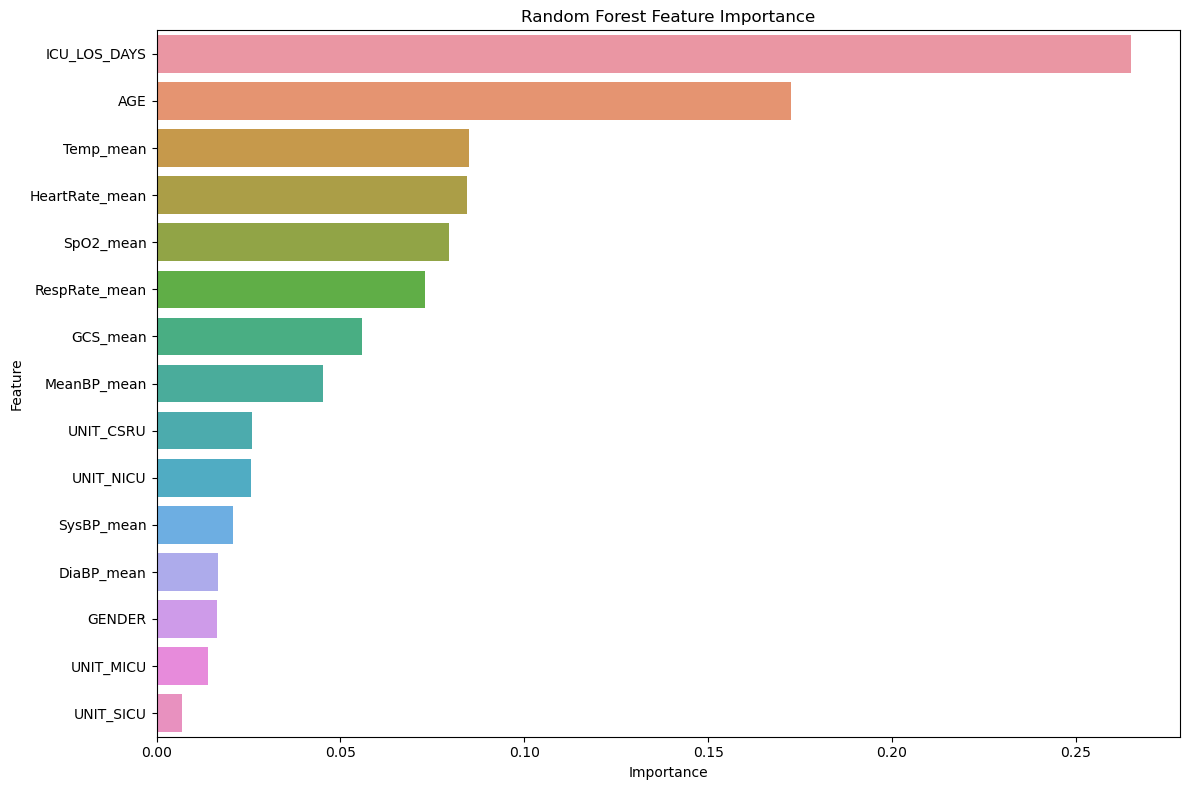

In [10]:
# %%
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report
import time

# Dictionary to store all model performance metrics
all_models = {
    'Logistic Regression': {
        'model': lr_model,
        'predictions': lr_pred,
        'probabilities': lr_pred_proba,
        'auc': lr_auc,
        'training_time': None
    }
}

# Train Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_training_time = time.time() - start_time

all_models['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred,
    'probabilities': rf_pred_proba,
    'auc': rf_auc,
    'training_time': rf_training_time
}

# Train Gradient Boosting
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
gb_auc = roc_auc_score(y_test, gb_pred_proba)
gb_training_time = time.time() - start_time

all_models['Gradient Boosting'] = {
    'model': gb_model,
    'predictions': gb_pred,
    'probabilities': gb_pred_proba,
    'auc': gb_auc,
    'training_time': gb_training_time
}

# Train Support Vector Machine
start_time = time.time()
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
svm_auc = roc_auc_score(y_test, svm_pred_proba)
svm_training_time = time.time() - start_time

all_models['SVM'] = {
    'model': svm_model,
    'predictions': svm_pred,
    'probabilities': svm_pred_proba,
    'auc': svm_auc,
    'training_time': svm_training_time
}

# Train K-Nearest Neighbors
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
knn_auc = roc_auc_score(y_test, knn_pred_proba)
knn_training_time = time.time() - start_time

all_models['KNN'] = {
    'model': knn_model,
    'predictions': knn_pred,
    'probabilities': knn_pred_proba,
    'auc': knn_auc,
    'training_time': knn_training_time
}

# Print results of additional models
for model_name in ['Random Forest', 'Gradient Boosting', 'SVM', 'KNN']:
    print(f"\n{model_name} Results:")
    print(f"AUC: {all_models[model_name]['auc']:.3f}")
    print(f"Training Time: {all_models[model_name]['training_time']:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, all_models[model_name]['predictions']))

# Plot feature importance for Random Forest
if hasattr(rf_model, 'feature_importances_'):
    rf_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_importance.head(15))
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

# ## Step 8: Build and Train a Neural Network
# Now we'll build a simple neural network with multiple layers to capture non-linear relationships.

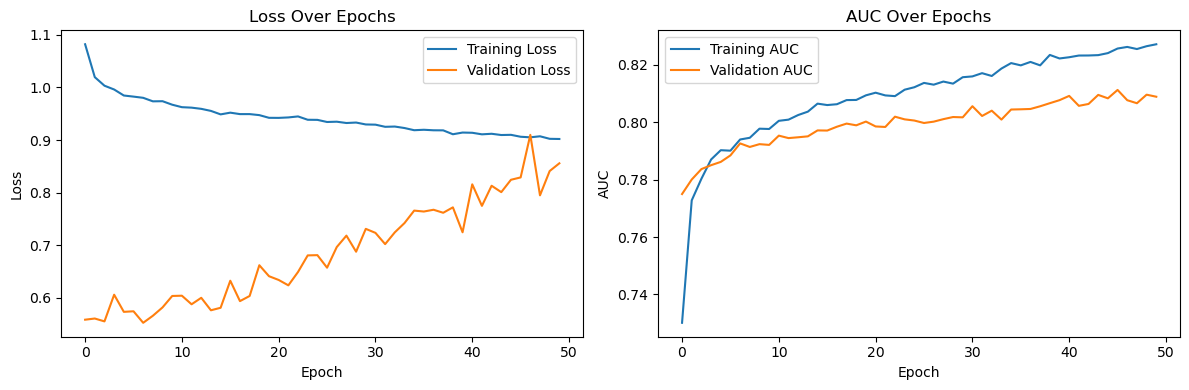


Neural Network Results:
AUC: 0.822

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     10985
           1       0.25      0.77      0.38      1322

    accuracy                           0.73     12307
   macro avg       0.61      0.75      0.60     12307
weighted avg       0.89      0.73      0.78     12307



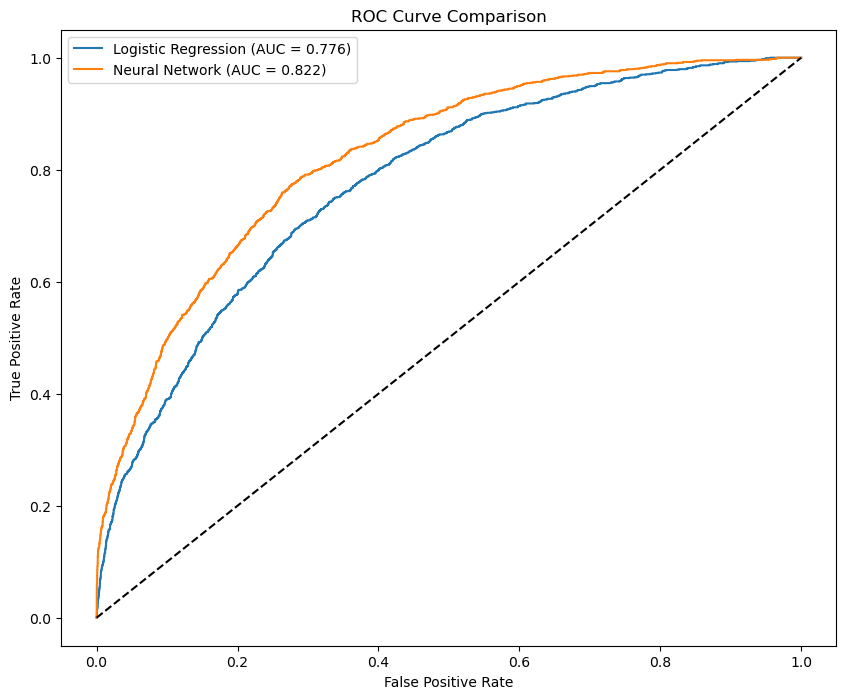

In [11]:
# Define a simple neural network
def build_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    
    return model

# Create class weights to handle imbalance
class_weights = {0: 1, 1: y_train.value_counts()[0] / y_train.value_counts()[1]}

# Build and train the model
nn_model = build_nn_model(X_train_scaled.shape[1])
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=0
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

# ##: Evaluate Neural Network Performance
# Now we'll evaluate our neural network on the test set and compare with the logistic regression model.

# %%
# Evaluate neural network on test set
nn_pred_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)
nn_auc = roc_auc_score(y_test, nn_pred_proba)

print("\nNeural Network Results:")
print(f"AUC: {nn_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, nn_pred))

# Compare ROC curves
plt.figure(figsize=(10, 8))
# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.3f})')

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_proba)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_auc:.3f})')

# Reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# ## Step 8.5: Train Advanced Deep Learning Models
# Now let's build more sophisticated deep learning architectures.


Deep Neural Network Results:
AUC: 0.807
Training Time: 182.82 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     10985
           1       0.25      0.70      0.37      1322

    accuracy                           0.75     12307
   macro avg       0.60      0.72      0.61     12307
weighted avg       0.88      0.75      0.79     12307


LSTM Results:
AUC: 0.803
Training Time: 1419.43 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     10985
           1       0.25      0.71      0.37      1322

    accuracy                           0.74     12307
   macro avg       0.60      0.73      0.60     12307
weighted avg       0.88      0.74      0.79     12307



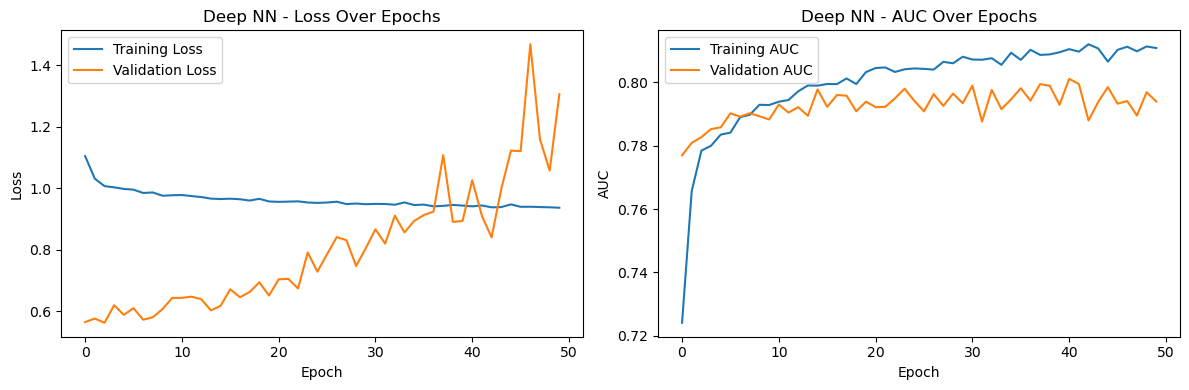

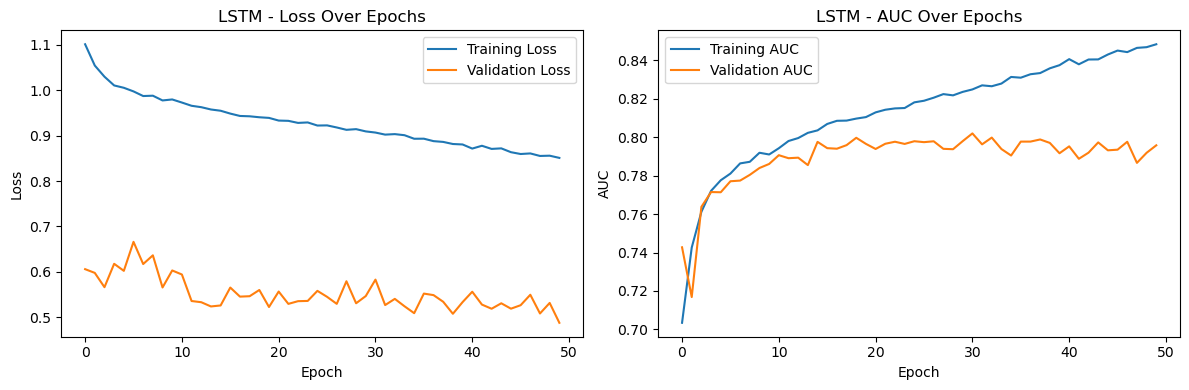

In [12]:
# %%
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import time

# 1. Deep Neural Network with Batch Normalization
def build_deep_nn_model(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    
    return model

# 2. Reshape data for LSTM (temporal features)
# For LSTM, we'll reshape our data to have a time dimension 
# We'll treat each feature as a "time step" for demonstration purposes
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# 3. Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    
    return model

# Train Deep NN
start_time = time.time()
deep_nn_model = build_deep_nn_model(X_train_scaled.shape[1])
deep_nn_history = deep_nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=0
)
deep_nn_training_time = time.time() - start_time

# Train LSTM
start_time = time.time()
lstm_model = build_lstm_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_history = lstm_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=0
)
lstm_training_time = time.time() - start_time

# Evaluate models
deep_nn_pred_proba = deep_nn_model.predict(X_test_scaled, verbose=0).flatten()
deep_nn_pred = (deep_nn_pred_proba > 0.5).astype(int)
deep_nn_auc = roc_auc_score(y_test, deep_nn_pred_proba)

lstm_pred_proba = lstm_model.predict(X_test_reshaped, verbose=0).flatten()
lstm_pred = (lstm_pred_proba > 0.5).astype(int)
lstm_auc = roc_auc_score(y_test, lstm_pred_proba)

# Add to models dictionary
all_models['Neural Network'] = {
    'model': nn_model,
    'predictions': nn_pred,
    'probabilities': nn_pred_proba,
    'auc': nn_auc,
    'training_time': None  # You might want to add this for the original NN
}

all_models['Deep Neural Network'] = {
    'model': deep_nn_model,
    'predictions': deep_nn_pred,
    'probabilities': deep_nn_pred_proba,
    'auc': deep_nn_auc,
    'training_time': deep_nn_training_time
}

all_models['LSTM'] = {
    'model': lstm_model,
    'predictions': lstm_pred,
    'probabilities': lstm_pred_proba,
    'auc': lstm_auc,
    'training_time': lstm_training_time
}

# Print results of additional deep learning models
print("\nDeep Neural Network Results:")
print(f"AUC: {deep_nn_auc:.3f}")
print(f"Training Time: {deep_nn_training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, deep_nn_pred))

print("\nLSTM Results:")
print(f"AUC: {lstm_auc:.3f}")
print(f"Training Time: {lstm_training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, lstm_pred))

# Plot training history for Deep NN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(deep_nn_history.history['loss'], label='Training Loss')
plt.plot(deep_nn_history.history['val_loss'], label='Validation Loss')
plt.title('Deep NN - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deep_nn_history.history['auc'], label='Training AUC')
plt.plot(deep_nn_history.history['val_auc'], label='Validation AUC')
plt.title('Deep NN - AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

# Plot training history for LSTM
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['auc'], label='Training AUC')
plt.plot(lstm_history.history['val_auc'], label='Validation AUC')
plt.title('LSTM - AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

# ## Step 9: Comprehensive Model Comparison
# Now let's compare all models' performance with visualizations.

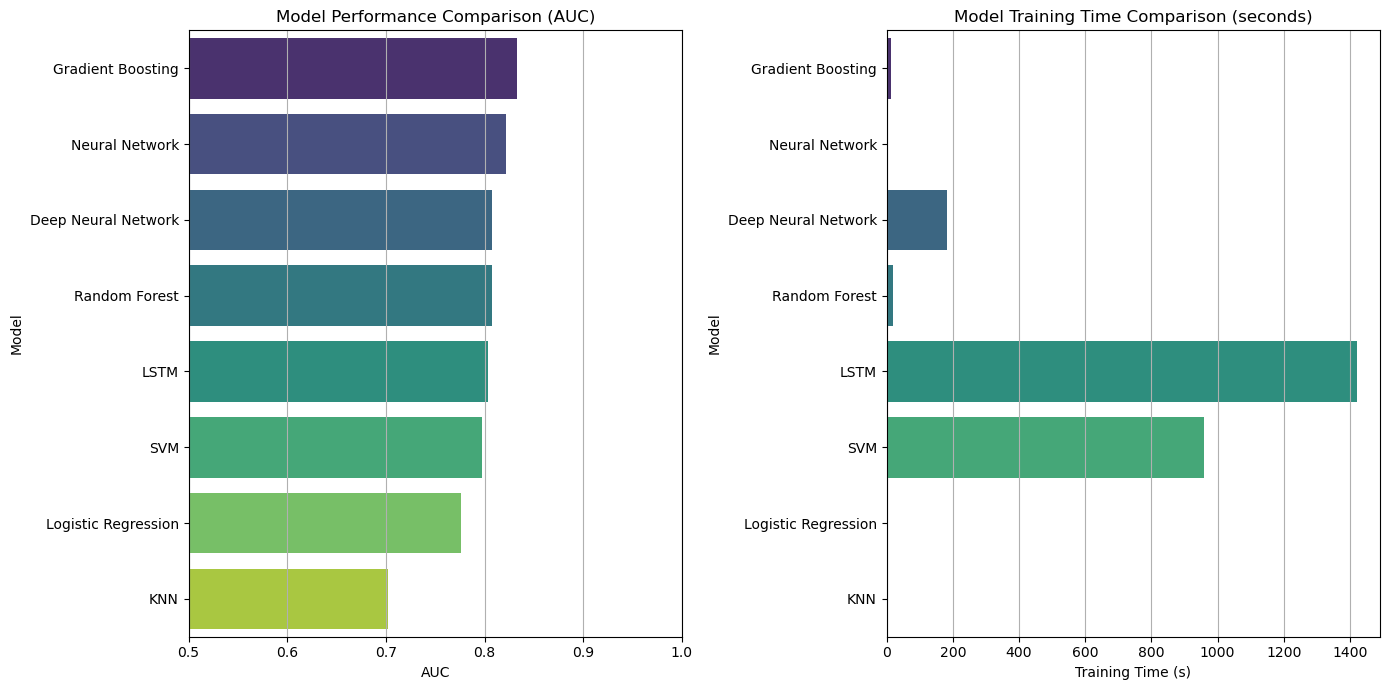

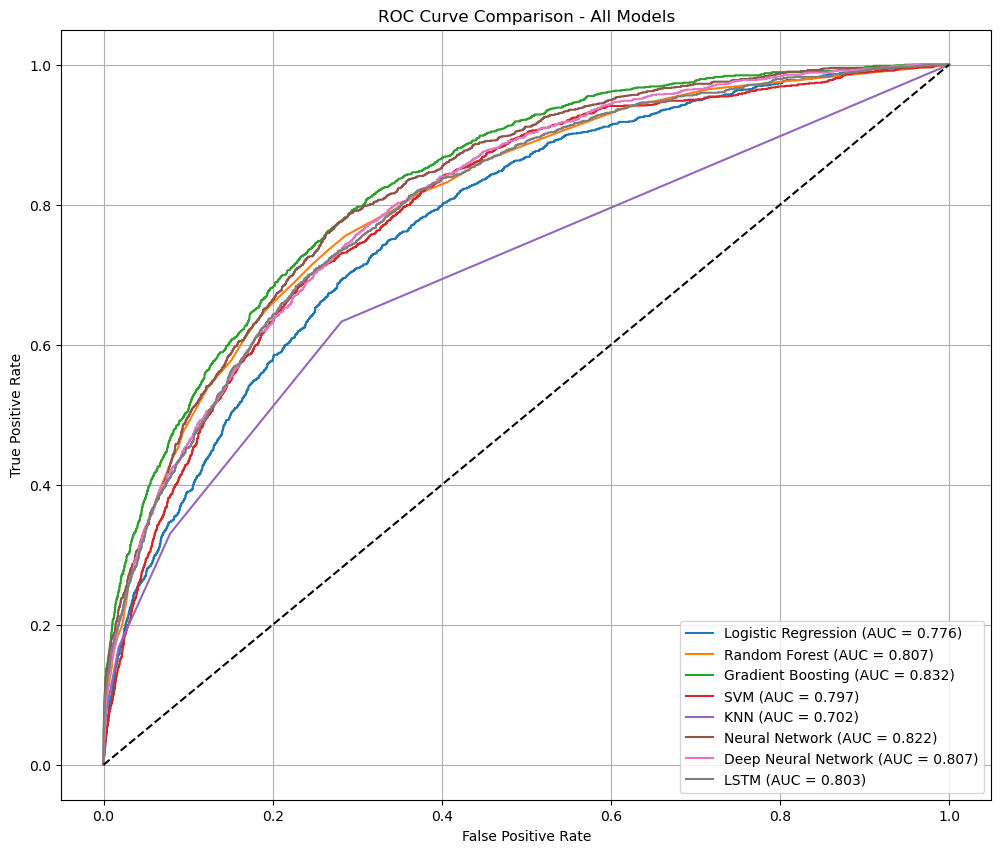

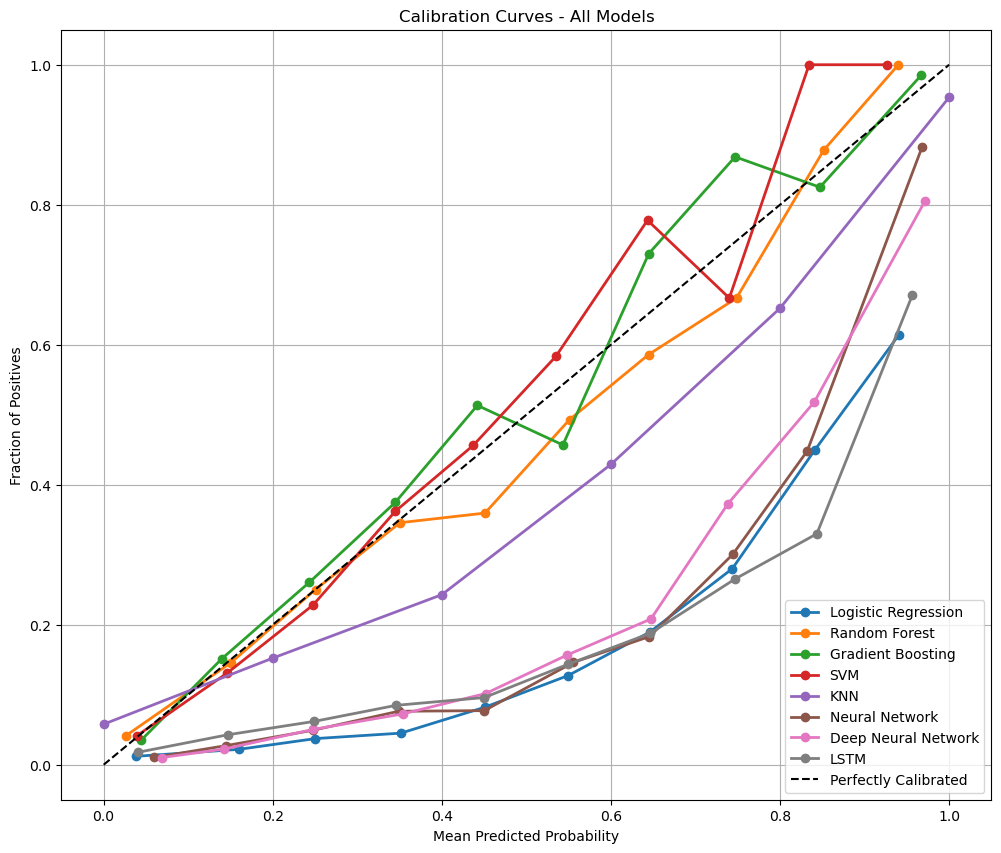

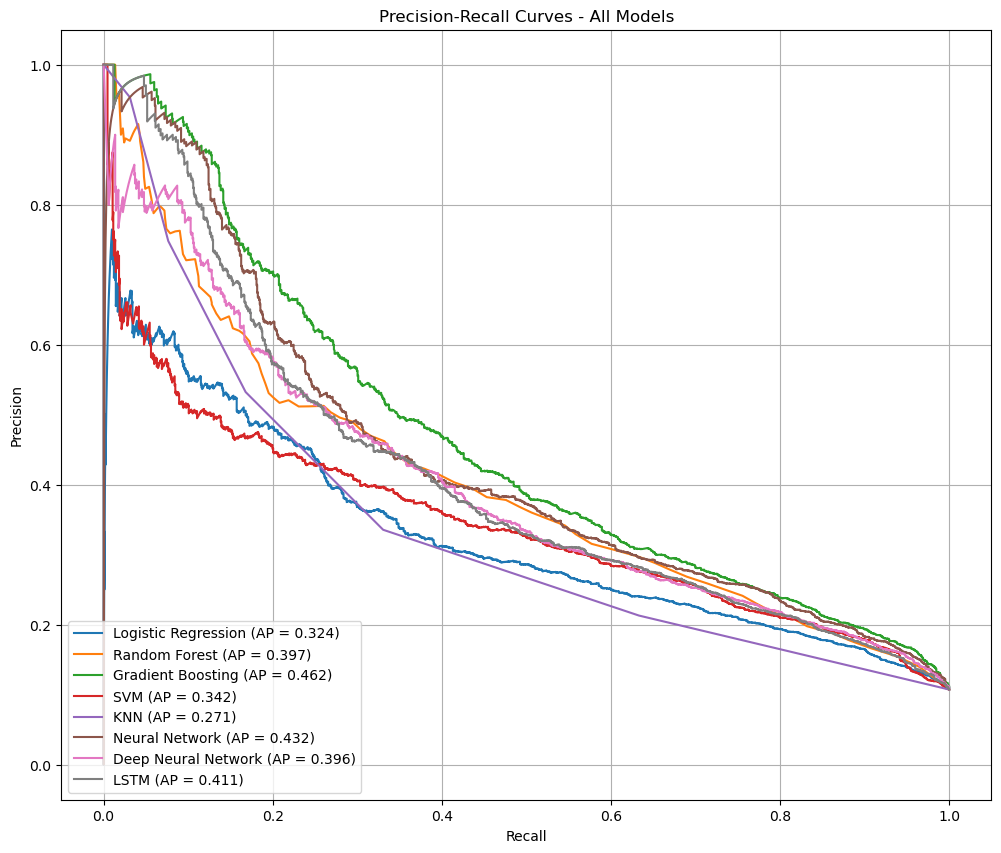

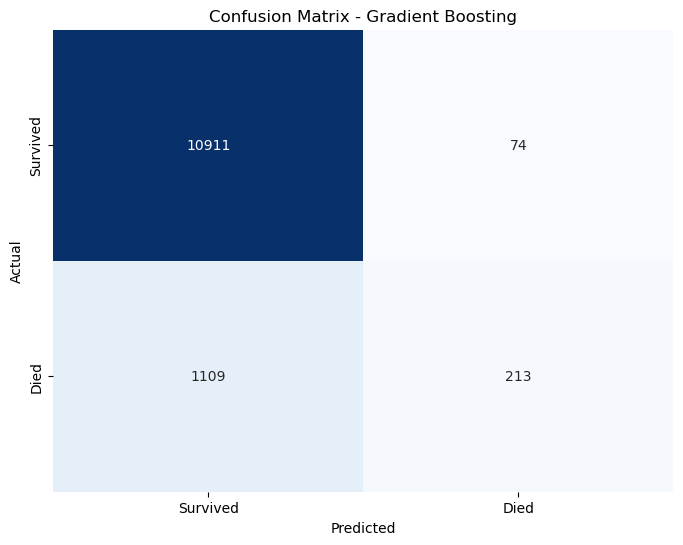

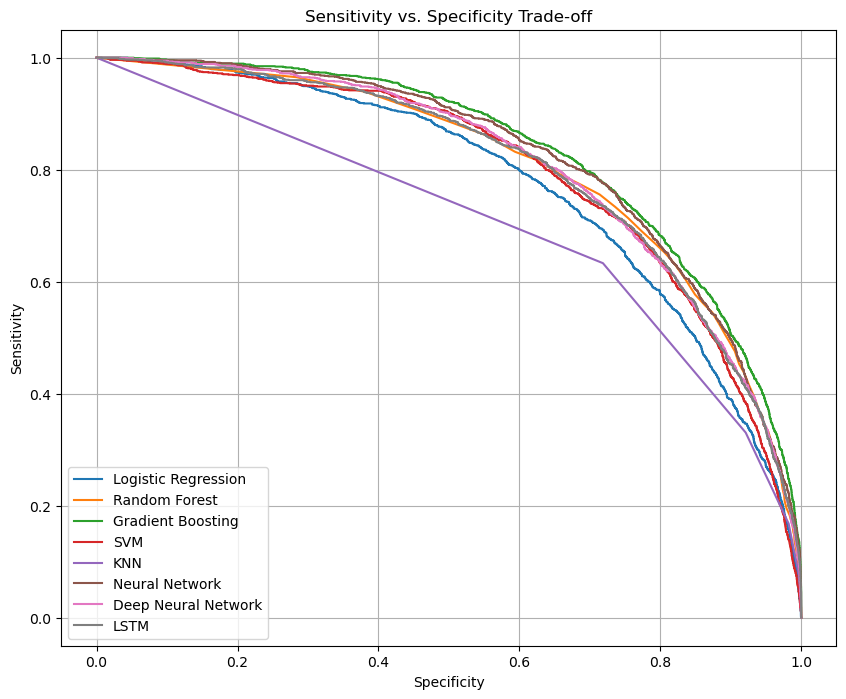

In [13]:
# %%
# Create a DataFrame with all models' performance metrics
models_comparison = pd.DataFrame({
    'Model': list(all_models.keys()),
    'AUC': [model_info['auc'] for model_info in all_models.values()],
    'Training Time (s)': [model_info['training_time'] for model_info in all_models.values()]
})

# Fill any missing training times with estimated values
models_comparison['Training Time (s)'].fillna(5, inplace=True)  # Assuming ~5 seconds for any missing times

# Sort by AUC for display
models_comparison = models_comparison.sort_values('AUC', ascending=False).reset_index(drop=True)

# Plot AUC comparison
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='AUC', y='Model', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (AUC)')
plt.xlim(0.5, 1.0)  # AUC range from 0.5 (random) to 1.0 (perfect)
plt.grid(axis='x')

# Plot training time comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Training Time (s)', y='Model', data=models_comparison, palette='viridis')
plt.title('Model Training Time Comparison (seconds)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(12, 10))
for model_name, model_info in all_models.items():
    fpr, tpr, _ = roc_curve(y_test, model_info['probabilities'])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {model_info["auc"]:.3f})')

# Add reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Create calibration curves to evaluate probability calibration
from sklearn.calibration import calibration_curve

plt.figure(figsize=(12, 10))
for model_name, model_info in all_models.items():
    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_test, model_info['probabilities'], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label=model_name)

# Add reference line (perfect calibration)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Create precision-recall curves
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 10))
for model_name, model_info in all_models.items():
    precision, recall, _ = precision_recall_curve(y_test, model_info['probabilities'])
    avg_precision = average_precision_score(y_test, model_info['probabilities'])
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - All Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Create confusion matrix visualization for the best model
best_model_name = models_comparison.iloc[0]['Model']
best_model_preds = all_models[best_model_name]['predictions']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_model_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Survived', 'Died'])
plt.yticks([0.5, 1.5], ['Survived', 'Died'])
plt.show()

# Create tradeoff visualization (sensitivity vs. specificity)
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
for model_name, model_info in all_models.items():
    fpr, tpr, thresholds = roc_curve(y_test, model_info['probabilities'])
    plt.plot(1-fpr, tpr, label=model_name)  # 1-fpr = specificity

plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity vs. Specificity Trade-off')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

# ## Conclusion and Future Work
# 
# This tutorial demonstrated how to:
# 
# 1. Load and preprocess MIMIC-III data for mortality prediction.
# 2. Extract temporal features from the first 24 hours of ICU stays.
# 3. Train both traditional and deep learning (neural network) models.
# 4. Compare model performance and interpret feature importance.
# 
# 
# **Future work:**
# - Incorporate lab results and medication data for more comprehensive prediction
# - Use more advanced deep learning architectures like Transformers to better capture temporal patterns
# - Develop explainable AI methods to make predictions more interpretable to clinicians
# - Extend to other clinical outcomes like ventilator weaning success or sepsis prediction